In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wget

import seaborn
import numpy as np
import pandas as pd
import pylab
import sklearn.preprocessing

import scgenome

import dbclients.tantalus


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Load segment data


In [2]:

tantalus_api = dbclients.tantalus.TantalusApi()

client = tantalus_api.get_storage_client('singlecellblob_results')

def read_blob_csv(url, dest):
    if not os.path.exists(dest):
        print 'downloading ', url
        filename = wget.download(url)
        os.rename(filename, dest)

    return pd.read_csv(dest)

# SA922
url = client.get_url('SC-878/results/results/hmmcopy/A90554B_reads.csv')
dest = 'A90554B_reads.csv'
data_sa922 = read_blob_csv(url, dest)

# SA921
url = client.get_url('SC-877/results/results/hmmcopy/A90554A_reads.csv')
dest = 'A90554A_reads.csv'
data_sa921 = read_blob_csv(url, dest)

# SA1090
url = client.get_url('SC-795/results/results/hmmcopy/A96213A_reads.csv')
dest = 'A96213A_reads.csv'
data_sa1090 = read_blob_csv(url, dest)

data_sa922['sample_id'] = data_sa922['cell_id'].apply(lambda a: a.split('-')[0])
data_sa921['sample_id'] = data_sa921['cell_id'].apply(lambda a: a.split('-')[0])
data_sa1090['sample_id'] = data_sa1090['cell_id'].apply(lambda a: a.split('-')[0])

data_sa922['external_sample_id'] = 'OV2295(R2)'
data_sa921['external_sample_id'] = 'TOV2295(R)'
data_sa1090['external_sample_id'] = 'OV2295'


In [3]:

cn_data = pd.concat([data_sa922, data_sa921, data_sa1090], ignore_index=True)

cn_data = cn_data[cn_data['sample_id'].isin(['SA922', 'SA921', 'SA1090'])]

cn_data['integer_copy_number'] = cn_data['state']



# Load metrics data


1966


,cell_id,unpaired_mapped_reads,paired_mapped_reads,unpaired_duplicate_reads,paired_duplicate_reads,unmapped_reads,percent_duplicate_reads,estimated_library_size,total_reads,total_mapped_reads,...,mad_neutral_state,breakpoints,mean_copy,state_mode,loglikehood,true_multiplier,too_even,jira_id,quality,sample_id
0,SA922-A90554B-R23-C03,393,604,0,3,338829,0.003748,60601.0,340430,1601,...,0.021077,61,2.261541,2,-611.204707,1.964997,False,SC-878,0.000,SA922
1,SA922-A90554B-R23-C05,398,1793,7,111,462902,0.057480,13877.0,466886,3984,...,0.000000,514,5.099099,4,1007.001969,4.000000,True,SC-878,0.000,SA922
2,SA922-A90554B-R23-C16,14787,761068,2692,73543,135428,0.097471,3680609.0,1672352,1536924,...,0.051489,131,4.275032,4,-5950.076400,4.961840,False,SC-878,0.658,SA922
3,SA922-A90554B-R23-C22,13409,699382,2227,61072,129954,0.088082,3768326.0,1542128,1412174,...,0.064229,105,3.967854,5,-5206.665804,4.096858,False,SC-878,0.662,SA922
4,SA922-A90554B-R23-C24,21658,1110243,4440,108243,205368,0.098549,5318193.0,2447512,2242144,...,0.029017,151,5.508476,6,-6172.309749,5.970744,False,SC-878,0.728,SA922


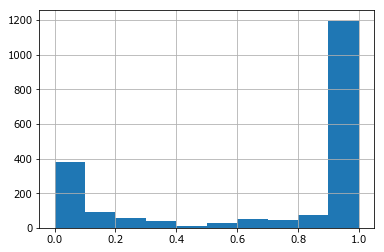

In [4]:

# SA922
url = client.get_url('SC-878/results/results/hmmcopy/A90554B_all_metrics_summary.csv')
dest = 'A90554B_metrics.csv'
metrics_sa922 = read_blob_csv(url, dest)

# SA921
url = client.get_url('SC-877/results/results/hmmcopy/A90554A_all_metrics_summary.csv')
dest = 'A90554A_metrics.csv'
metrics_sa921 = read_blob_csv(url, dest)

# SA1090
url = client.get_url('SC-795/results/results/hmmcopy/A96213A_all_metrics_summary.csv')
dest = 'A96213A_metrics.csv'
metrics_sa1090 = read_blob_csv(url, dest)

metrics_sa922['sample_id'] = metrics_sa922['cell_id'].apply(lambda a: a.split('-')[0])
metrics_sa921['sample_id'] = metrics_sa921['cell_id'].apply(lambda a: a.split('-')[0])
metrics_sa1090['sample_id'] = metrics_sa1090['cell_id'].apply(lambda a: a.split('-')[0])

data_sa922['external_sample_id'] = 'OV2295(R2)'
data_sa921['external_sample_id'] = 'TOV2295(R)'
data_sa1090['external_sample_id'] = 'OV2295'

metrics_data = pd.concat([metrics_sa922, metrics_sa921, metrics_sa1090])
metrics_data = metrics_data[metrics_data['sample_id'].isin(['SA922', 'SA921', 'SA1090'])]
metrics_data['quality'].hist()
print len(metrics_data['cell_id'].unique())
metrics_data.head()



# Filtering


1966
1542
1345


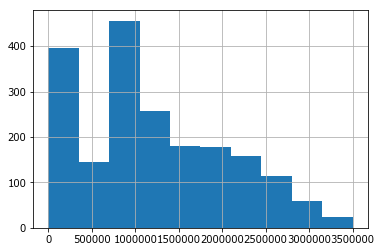

In [5]:

cn_data.groupby('cell_id')['reads'].sum().hist()

cell_read_counts = cn_data.groupby('cell_id')['reads'].sum().rename('total_reads')
cell_read_counts = cell_read_counts[cell_read_counts > 500000]

filtered_cell_ids = metrics_data[metrics_data['quality'] > 0.5][['cell_id']].drop_duplicates()

print len(cn_data['cell_id'].unique())
cn_data = cn_data.merge(cell_read_counts.reset_index())
print len(cn_data['cell_id'].unique())
cn_data = cn_data.merge(filtered_cell_ids.reset_index())
print len(cn_data['cell_id'].unique())


In [6]:

import scgenome.cncluster

cn = cn_data.set_index(['chr', 'start', 'cell_id'])['integer_copy_number'].unstack(level=2).fillna(0)

cluster_df = scgenome.cncluster.umap_hdbscan_cluster(cn)

if 'cluster_id' in cn_data:
    cn_data.drop('cluster_id', axis=1, inplace=True)

cn_data = cn_data.merge(cluster_df)

if 'clone_cn' in cn_data:
    cn_data.drop('clone_cn', axis=1, inplace=True)

clone_cn = (
    cn_data.groupby(['chr', 'start', 'cluster_id'])['integer_copy_number']
    .median().rename('clone_cn').reset_index())
cn_data = cn_data.merge(clone_cn)

cluster_df.groupby('cluster_id').size().rename('size').reset_index()


,cluster_id,size
0,-1,36
1,0,35
2,1,34
3,2,213
4,3,49
5,4,191
6,5,138
7,6,154
8,7,81
9,8,38


KeyError: 'umap1'

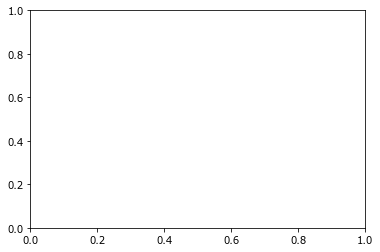

In [100]:

scgenome.cncluster.plot_umap_clusters(plt.gca(), cluster_df)


In [101]:

# cn_data2 = cn_data.copy()
# cn_data2['clone_var'] = np.square(cn_data2['integer_copy_number'] - cn_data2['clone_cn'])
# clone_std = cn_data2.groupby('cell_id')['clone_var'].sum().pow(1./2).rename('clone_std').reset_index()
# clone_rms = cn_data2.groupby('cell_id')['clone_var'].mean().pow(1./2).rename('clone_rms').reset_index()

# cluster_df = cluster_df.merge(clone_std)
# cluster_df = cluster_df.merge(clone_rms)

# cluster_df['clone_std'] = cluster_df['clone_std']#.clip_upper(75.)

# fig = plt.figure(figsize=(8, 8))
# plt.scatter(
#     cluster_df['umap1'].values,
#     cluster_df['umap2'].values,
#     c=cluster_df['clone_std'].values,
#     cmap=plt.get_cmap("Reds"),
#     s=2)

# fig = plt.figure()
# cluster_df['clone_std'].hist(bins=30)

# print len(cluster_df['cell_id'].unique())
# cluster_df = cluster_df[cluster_df['clone_std'] < 60.]
# print len(cluster_df['cell_id'].unique())
# clone_counts = cluster_df.groupby('cluster_id')['cell_id'].count()
# print clone_counts
# clone_counts_filter = clone_counts[clone_counts >= 50].reset_index()
# cluster_df = cluster_df.merge(clone_counts_filter[['cluster_id']])
# print len(cluster_df['cell_id'].unique())
# print cluster_df.groupby('cluster_id')['cell_id'].count().describe()

# cluster_df['is_filtered'] = cluster_df['clone_std'] < 60.
# seaborn.factorplot(data=cluster_df, x='is_filtered', y='clone_std', kind='strip', jitter=True)
# seaborn.factorplot(data=cluster_df, x='is_filtered', y='clone_rms', kind='strip', jitter=True)

# cn_data_filtered = cn_data[cn_data['cell_id'].isin(cluster_df['cell_id'].unique())]

# cluster_df.groupby('is_filtered')['clone_std'].describe()
# cluster_df.groupby('is_filtered')['clone_rms'].describe()

# cluster_df = pd.read_csv('ov2295_umap_clusters.tsv', sep='\t').rename(columns={'gm_umap_cluster': 'cluster_id'})

cn_data_filtered = cn_data.drop('cluster_id', axis=1).merge(cluster_df)
cn_data_filtered = cn_data_filtered.query('cluster_id >= 0')

# cn_data_filtered.head()


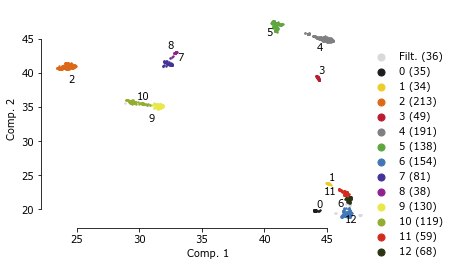

In [9]:

scgenome.cncluster.plot_umap_clusters(plt.gca(), cluster_df)


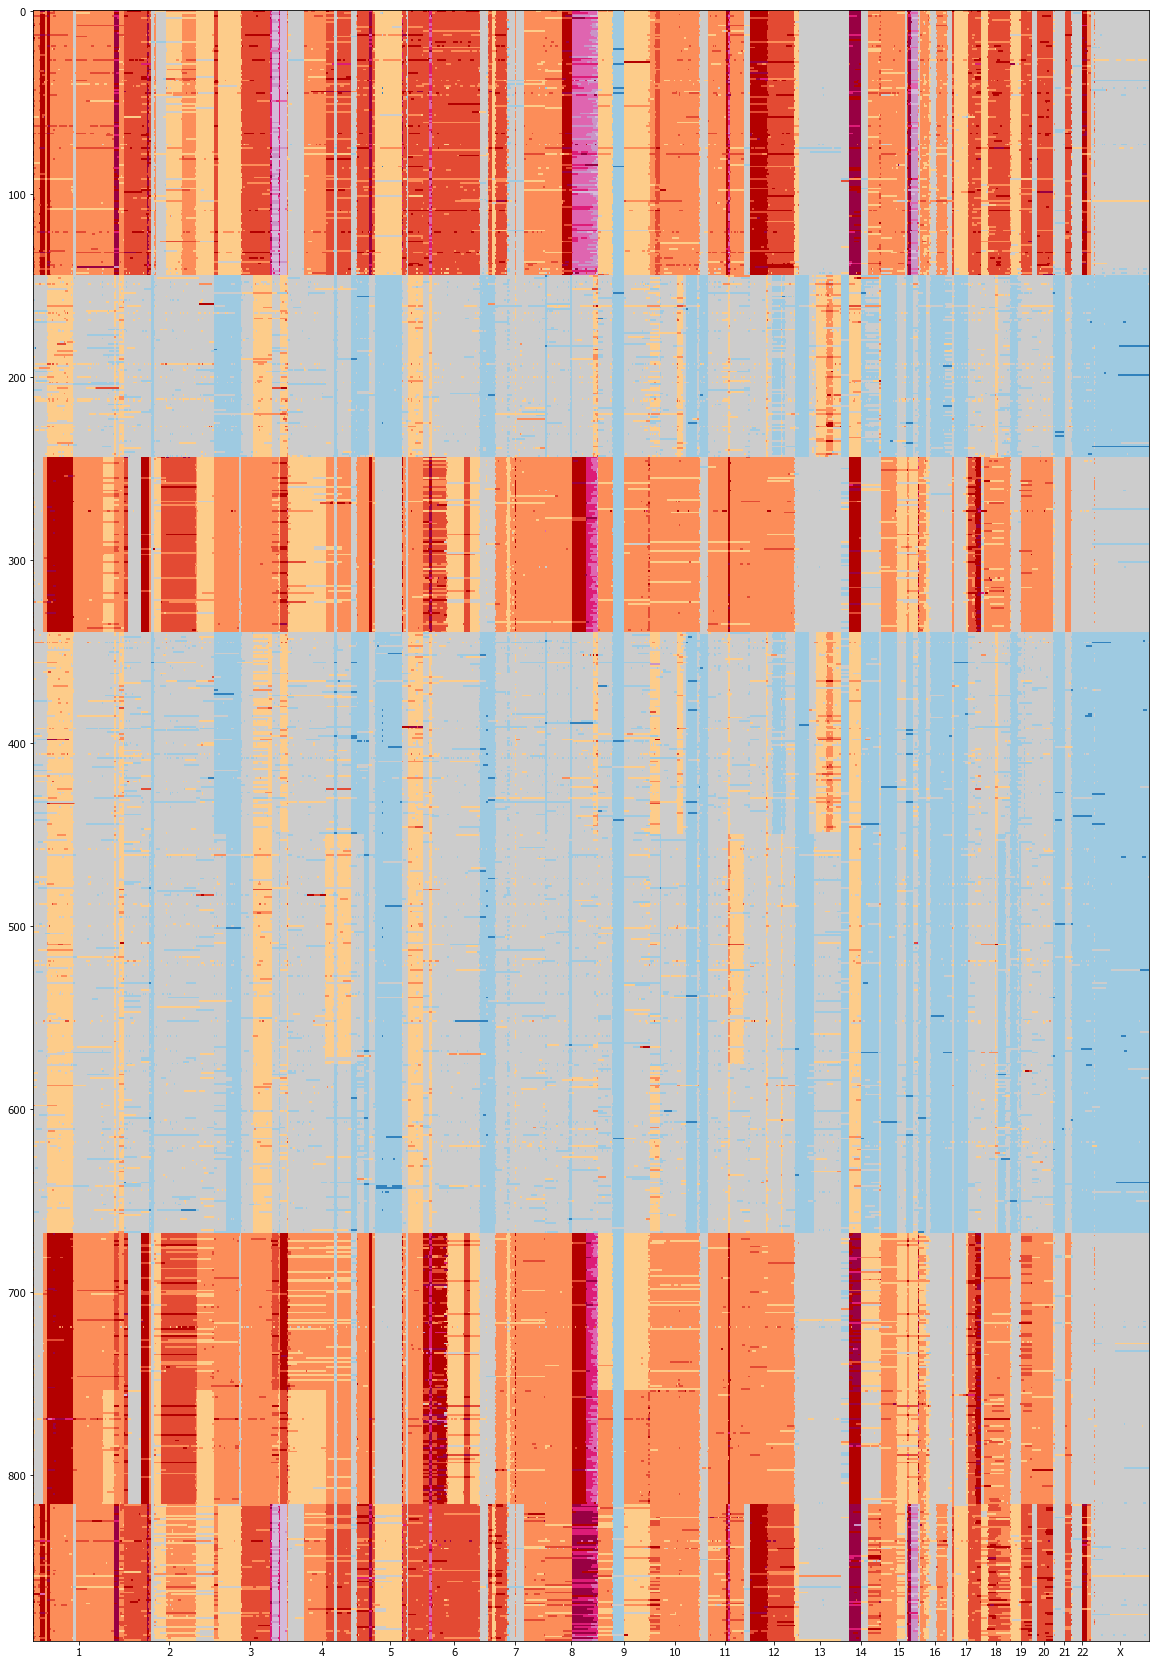

In [102]:

import scgenome.cnplot

fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_clustered_cell_cn_matrix(ax, cn_data_filtered, 'integer_copy_number')


In [103]:

cn_data.head()


,chr,start,end,width,reads,gc,map,cor_gc,copy,valid,...,cell_id,sample_id,external_sample_id,integer_copy_number,total_reads,index,cluster_id,umap1,umap2,clone_cn
0,1,1,500000,500000,3,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C16,SA922,OV2295(R2),4,1304471,2,6,46.871273,19.926632,5.0
1,1,1,500000,500000,12,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C22,SA922,OV2295(R2),5,1209382,3,6,46.802898,19.608337,5.0
2,1,1,500000,500000,15,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C26,SA922,OV2295(R2),6,2611129,5,6,46.854229,19.217529,5.0
3,1,1,500000,500000,11,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C30,SA922,OV2295(R2),5,2717667,9,6,46.201958,18.893251,5.0
4,1,1,500000,500000,6,-1.0,0.348523,NaN,NaN,False,...,SA922-A90554B-R23-C33,SA922,OV2295(R2),4,986260,12,6,46.353325,19.977528,5.0


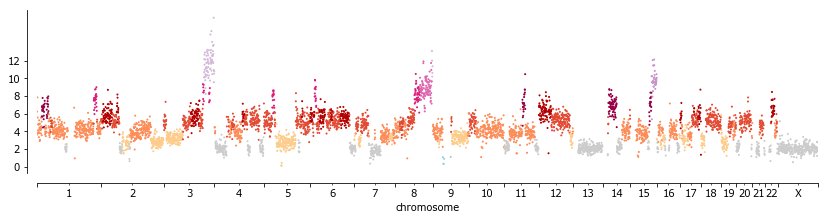

In [104]:

import matplotlib

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cell_cn_profile(
    ax, cn_data_filtered.query('cell_id == "SA922-A90554B-R23-C16"'), 'copy', 'integer_copy_number')


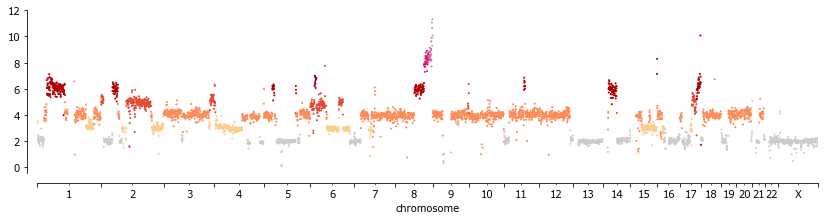

In [113]:

clone_cn_state = (
    cn_data_filtered.groupby(['chr', 'start', 'end', 'cluster_id'])['integer_copy_number']
    .median().astype(int).reset_index())

clone_cn_copy = (
    cn_data_filtered.groupby(['chr', 'start', 'end', 'cluster_id'])['copy']
    .mean().reset_index())

clone_cn_data = clone_cn_state.merge(clone_cn_copy)

clone_cn_data.to_csv('ov2295_clone_cn.csv', index=False)

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cell_cn_profile(
    ax, clone_cn_data.query('cluster_id == 6'), 'copy', 'integer_copy_number')


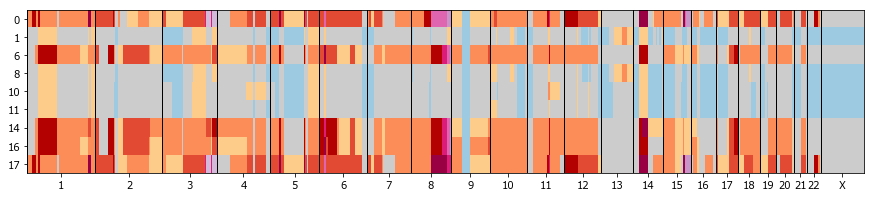

In [106]:

import scgenome.cnplot

fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cluster_cn_matrix(ax, cn_data_filtered, 'integer_copy_number')


In [23]:

def get_snp_results(sas, url, dest):
    if not os.path.exists(dest):
        filename = wget.download(url + sas)
        os.rename(filename, dest)

    store = pd.HDFStore(dest)

    return store

snp_urls = [
    (
        'SC-964',
        '?st=2018-05-10T13%3A45%3A00Z&se=2019-05-11T13%3A45%3A00Z&sp=rl&sv=2017-04-17&sr=c&sig=mnF86F4FGvMSLptwQXyAu%2FeJUZen%2Bj2wYPZFjW1cXxE%3D',
        'https://singlecelldata.blob.core.windows.net/results/SC-964/results/copynumber/results/het_counts.h5',
        'het_counts_SC-964.h5'
    ),
    (
        'SC-965',
        '?st=2018-05-10T13%3A45%3A00Z&se=2019-05-11T13%3A45%3A00Z&sp=rl&sv=2017-04-17&sr=c&sig=mnF86F4FGvMSLptwQXyAu%2FeJUZen%2Bj2wYPZFjW1cXxE%3D',
        'https://singlecelldata.blob.core.windows.net/results/SC-965/results/copynumber/results/het_counts.h5',
        'het_counts_SC-965.h5'
    ),
    (
        'SC-704',
        '?st=2018-05-10T13%3A45%3A00Z&se=2019-05-11T13%3A45%3A00Z&sp=rl&sv=2017-04-17&sr=c&sig=mnF86F4FGvMSLptwQXyAu%2FeJUZen%2Bj2wYPZFjW1cXxE%3D',
        'https://singlecelldata.blob.core.windows.net/results/SC-704/results/copynumber/results/het_counts.h5',
        'het_counts_SC-704.h5'
    ),
]

snp_data_list = {key: get_snp_results(sas, url, dest) for key, sas, url, dest in snp_urls}


In [27]:

import scgenome.snpdata

scgenome.snpdata.get_clone_snp_count(snp_data_list['SC-704'], cluster_df)

# scgenome.snpdata.calculate_haplotype_allele_counts(snp_data, haps, 500000)

# het_counts_filename = 'het_counts_SC-964.h5'
# for chunk in pd.read_hdf(het_counts_filename, '/snv/mappability', chunksize=int(1e5)):
#     pass

# print chunk.head*()


414
. . . . . . . . . . . . . . . . . . . .

KeyboardInterrupt: 

In [ ]:

def get_clone_snp_count(het_counts_filename, haps):
    for chunk in pd.read_hdf(het_counts_filename, '/snv/mappability', chunksize=int(1e5)):
    
    cell_ids = het_counts['cell_ids']
    cell_ids.set_index('cell_id', inplace=True)

    snp_data = None

    cluster_df = cluster_df.merge(cell_ids.reset_index()[['cell_id']].drop_duplicates())

    print cluster_df.shape[0]
    for cell_id, cluster_id in cluster_df[['cell_id', 'cluster_id']].values:
        print '.',
        cell_index = cell_ids.loc[cell_id, 'cell_index']
        df = het_counts.select('/allele_counts', where='cell_index=={}'.format(cell_index))
        df['cluster_id'] = cluster_id
        df['chromosome'] = df['chromosome'].astype(str)
        if snp_data is None:
            snp_data = df
        else:
            snp_data = pd.concat([snp_data, df], ignore_index=True)
            snp_data = snp_data.groupby(['chromosome', 'coord', 'cluster_id'])[['ref_counts', 'alt_counts']].sum().reset_index()

    snp_data['total_counts'] = snp_data['ref_counts'] + snp_data['alt_counts']
    snp_data['vaf'] = snp_data['alt_counts'] / snp_data['total_counts'].astype(float)

    return snp_data


In [30]:
print 'done'

done


In [ ]:

import scgenome.snpdata

snp_data = []
for jira_id, het_counts_store in snp_data_list.iteritems():
    snp_data.append(scgenome.snpdata.get_clone_snp_count(het_counts_store, cluster_df))
snp_data = pd.concat(snp_data, ignore_index=True)
    
with pd.HDFStore('ov2295_snps.h5', 'w') as store:
    store['snps'] = snp_data
    print store['snps'].head()



 554
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 377
. . . . . . . . . . . . . . . . . . . . . . .


## Load cached SNP data


In [71]:

with pd.HDFStore('ov2295_snps.h5') as store:
    snp_data = store['snps']

snp_data['chromosome'] = snp_data['chromosome'].astype(str)
snp_data.head()


,chromosome,coord,cluster_id,ref_counts,alt_counts,total_counts,vaf
0,1,10583,1,3,0,3,0.000000
1,1,10583,8,2,2,4,0.500000
2,1,10583,11,3,0,3,0.000000
3,1,13302,1,9,4,13,0.307692
4,1,13302,8,7,4,11,0.363636


In [86]:

import scgenome.snpdata

haps = pd.read_csv('ov2295_haps.tsv', sep='\t', converters={'chromosome': str})

hap_data = scgenome.snpdata.calculate_haplotype_allele_counts(snp_data, haps, 500000)
print hap_data['cluster_id'].unique()
hap_data.query('cluster_id == 6').head(10)


[ 0  1  6  8 10 11 14 16 17]


,chr,start,end,hap_label,cluster_id,allele_1_sum,allele_2_sum,total_counts_sum
217529,1,1,500000,0,6,6,3,9
217530,1,1,500000,1,6,3,0,3
217531,1,1,500000,2,6,0,3,3
217532,1,1,500000,4,6,6,11,17
217533,1,1,500000,5,6,13,0,13
217534,1,1,500000,6,6,3,0,3
217535,1,500001,1000000,7,6,0,1,1
217536,1,500001,1000000,8,6,5,8,13
217537,1,500001,1000000,9,6,1,7,8
217538,1,500001,1000000,10,6,2,0,2


In [146]:

sa921_allele_counts = pd.read_csv(os.path.join('/Users/amcphers/Scratch/tov', 'SA921_allele_counts.csv'))
sa922_allele_counts = pd.read_csv(os.path.join('/Users/amcphers/Scratch/tov', 'SA922_allele_counts.csv'))
sa1090_allele_counts = pd.read_csv(os.path.join('/Users/amcphers/Scratch/tov', 'SA1090_allele_counts.csv'))

allele_counts = pd.concat([
    sa921_allele_counts,
    sa922_allele_counts,
    sa1090_allele_counts,
], ignore_index=True)

allele_counts.head()


,allele_id,cell_id,chromosome,end,hap_label,readcount,start
0,0,SA921-A90554A-R12-C09,1,7000000,420,1,6500000
1,1,SA921-A90554A-R12-C09,1,43500000,1799,1,43000000
2,0,SA921-A90554A-R12-C09,1,44000000,1817,1,43500000
3,0,SA921-A90554A-R12-C09,1,51500000,2023,1,51000000
4,1,SA921-A90554A-R12-C09,1,61000000,2292,1,60500000


In [147]:

# SA1090-A96213A-R34-C08
sa1090_allele_counts.query('cell_id == "SA1090-A96213A-R34-C08"').query('chromosome == "1"').query('end == 1000000')


,allele_id,cell_id,chromosome,end,hap_label,readcount,start
8805998,0,SA1090-A96213A-R34-C08,1,1000000,9,1,521368
8805999,1,SA1090-A96213A-R34-C08,1,1000000,27,4,521368
8806000,0,SA1090-A96213A-R34-C08,1,1000000,30,1,521368


In [148]:

print sa921_allele_counts[sa921_allele_counts.duplicated(index_cols + ['cell_id', 'allele_id'], keep=False)].sort_values(index_cols)


Empty DataFrame
Columns: [allele_id, cell_id, chromosome, end, hap_label, readcount, start]
Index: []


In [149]:

cluster_df = pd.read_csv('ov2295_umap_clusters.tsv', sep='\t')
cluster_df['cluster_id'] = cluster_df['gm_umap_cluster']

index_cols = [
    'chromosome',
    'start',
    'end',
    'hap_label',
]

bin_size = 500000

allele_counts = allele_counts.set_index(index_cols + ['cell_id', 'allele_id'])['readcount'].unstack(fill_value=0)
allele_counts.rename(columns={0: 'allele_1', 1: 'allele_2'}, inplace=True)
allele_counts.reset_index(inplace=True)
allele_counts = allele_counts.merge(cluster_df)
allele_counts = allele_counts.groupby(index_cols + ['cluster_id'])[['allele_1', 'allele_2']].sum().reset_index()
allele_counts['total'] = allele_counts['allele_1'] + allele_counts['allele_2']
allele_counts['start'] = (allele_counts['start'] / bin_size).astype(int) * bin_size + 1
allele_counts['end'] = allele_counts['start'] + bin_size - 1
allele_counts.head()


,chromosome,start,end,hap_label,cluster_id,allele_1,allele_2,total
0,1,1,500000,0,0,4,4,8
1,1,1,500000,0,1,1,7,8
2,1,1,500000,0,6,4,1,5
3,1,1,500000,0,8,1,7,8
4,1,1,500000,0,10,1,4,5


In [150]:

allele_counts.query('cluster_id == 6').head(10)


,chromosome,start,end,hap_label,cluster_id,allele_1,allele_2,total
2,1,1,500000,0,6,4,1,5
15,1,1,500000,2,6,2,0,2
22,1,1,500000,3,6,0,2,2
28,1,1,500000,4,6,16,3,19
37,1,1,500000,5,6,2,0,2
50,1,500001,1000000,7,6,5,3,8
59,1,500001,1000000,8,6,6,1,7
68,1,500001,1000000,9,6,2,0,2
76,1,500001,1000000,10,6,4,0,4
84,1,500001,1000000,11,6,3,4,7


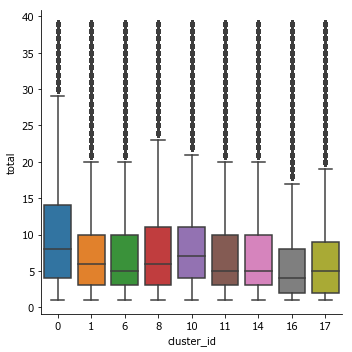

In [151]:

plot_data = allele_counts.query('total < 40')
seaborn.factorplot(x='cluster_id', y='total', kind='box', data=plot_data)


In [152]:

import scgenome.snpdata

data = allele_counts.rename(columns={
    'chromosome': 'chr',
    'total': 'total_counts_sum',
    'allele_1': 'allele_1_sum',
    'allele_2': 'allele_2_sum',
})

hap_data = data.copy()

hap_data = hap_data[hap_data['total_counts_sum'] > 5].copy()

hap_data['maf'] = (
    np.minimum(hap_data['allele_1_sum'], hap_data['allele_2_sum']) /
    hap_data['total_counts_sum'].astype(float))

allele_cn = scgenome.snpdata.infer_allele_cn(clone_cn_data, data)

allele_cn['maf'] = (
    np.minimum(allele_cn['allele_1_sum'], allele_cn['allele_2_sum']) /
    allele_cn['total_counts_sum'].astype(float))

allele_cn.query('chr == "4"').query('total_counts_sum > 100').head(40)


,chr,start,end,cluster_id,total_cn,copy,hap_label,allele_1_sum,allele_2_sum,total_counts_sum,minor_cn,major_cn,maf
586392,4,1,500000,0,4.0,0.000000,2.0,361.0,312.0,673.0,1,3.0,0.463596
586403,4,1,500000,0,4.0,0.000000,13.0,523.0,608.0,1131.0,1,3.0,0.462423
586405,4,1,500000,0,4.0,0.000000,15.0,213.0,228.0,441.0,1,3.0,0.482993
586413,4,1,500000,1,3.0,0.000000,2.0,245.0,444.0,689.0,1,2.0,0.355588
586424,4,1,500000,1,3.0,0.000000,13.0,426.0,888.0,1314.0,1,2.0,0.324201
586426,4,1,500000,1,3.0,0.000000,15.0,188.0,360.0,548.0,1,2.0,0.343066
586434,4,1,500000,6,5.0,0.000000,2.0,131.0,523.0,654.0,1,4.0,0.200306
586445,4,1,500000,6,5.0,0.000000,13.0,207.0,837.0,1044.0,1,4.0,0.198276
586447,4,1,500000,6,5.0,0.000000,15.0,75.0,291.0,366.0,1,4.0,0.204918
586455,4,1,500000,8,3.0,0.000000,2.0,301.0,539.0,840.0,1,2.0,0.358333


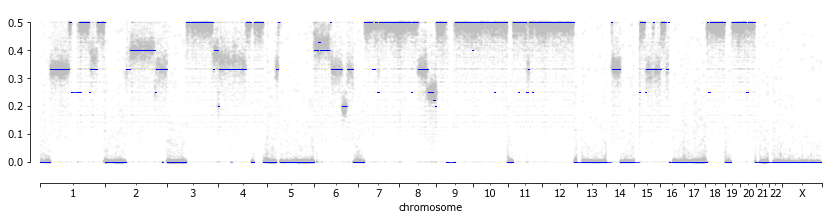

In [154]:

plot_cluster_id = 6

hap_data['maf'] = (
    np.minimum(hap_data['allele_1_sum'], hap_data['allele_2_sum']) /
    hap_data['total_counts_sum'].astype(float))

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.snpdata.plot_cell_vaf_profile(
    ax, hap_data.query('cluster_id == {}'.format(plot_cluster_id)), 'maf',
    size_field_name='total_counts_sum',
    size_scale=100.,
)   

allele_cn['cn_ratio'] = allele_cn['minor_cn'] / allele_cn['total_cn']

import scgenome.refgenome as refgenome
from matplotlib import collections  as mc

plot_data = allele_cn.query('cluster_id == {}'.format(plot_cluster_id)).copy()
plot_data = plot_data[plot_data['chr'].isin(refgenome.info.chromosomes)]

plot_data.set_index('chr', inplace=True)
plot_data['chromosome_start'] = refgenome.info.chromosome_start
plot_data.reset_index(inplace=True)

plot_data['start'] = plot_data['start'] + plot_data['chromosome_start']
plot_data['end'] = plot_data['end'] + plot_data['chromosome_start']

lines = np.zeros((plot_data.shape[0], 2, 2))
lines[:, 0, 0] = plot_data['start'].values
lines[:, 1, 0] = plot_data['end'].values
lines[:, 0, 1] = plot_data['cn_ratio'].values
lines[:, 1, 1] = plot_data['cn_ratio'].values

lc = mc.LineCollection(lines, colors='b', linewidths=1.)
ax.add_collection(lc)



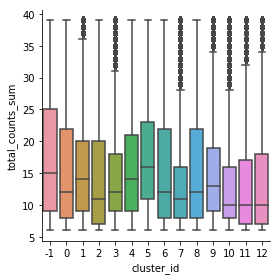

In [35]:

# Filtering haplotype blocks
plot_data = hap_data.query('total_counts_sum < 40')
seaborn.factorplot(x='cluster_id', y='total_counts_sum', kind='box', data=plot_data)
hap_data = hap_data[hap_data['total_counts_sum'] > 5]



## Infer allele specific CN


In [155]:

allele_cn = scgenome.snpdata.infer_allele_cn(clone_cn_data, hap_data)
allele_cn.head()


,chr,start,end,cluster_id,total_cn,copy,hap_label,allele_1_sum,allele_2_sum,total_counts_sum,maf,minor_cn,major_cn
0,1,1,500000,0,5.0,0.0,0.0,4.0,4.0,8.0,0.500000,0,5.0
1,1,1,500000,0,5.0,0.0,2.0,6.0,1.0,7.0,0.142857,0,5.0
2,1,1,500000,1,2.0,0.0,0.0,1.0,7.0,8.0,0.125000,0,2.0
3,1,1,500000,1,2.0,0.0,4.0,8.0,4.0,12.0,0.333333,0,2.0
4,1,1,500000,1,2.0,0.0,5.0,1.0,5.0,6.0,0.166667,0,2.0



## Allele plot for clone 1


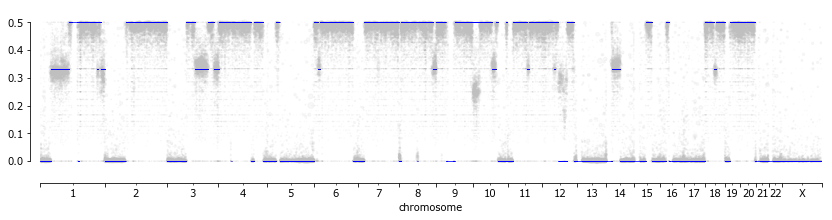

In [156]:

hap_data['maf'] = (
    np.minimum(hap_data['allele_1_sum'], hap_data['allele_2_sum']) /
    hap_data['total_counts_sum'].astype(float))

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.snpdata.plot_cell_vaf_profile(
    ax, hap_data.query('cluster_id == 1'), 'maf',
    size_field_name='total_counts_sum',
    size_scale=100.,
)   

allele_cn['cn_ratio'] = allele_cn['minor_cn'] / allele_cn['total_cn']

import scgenome.refgenome as refgenome
from matplotlib import collections  as mc

plot_data = allele_cn.query('cluster_id == 1').copy()
plot_data = plot_data[plot_data['chr'].isin(refgenome.info.chromosomes)]

plot_data.set_index('chr', inplace=True)
plot_data['chromosome_start'] = refgenome.info.chromosome_start
plot_data.reset_index(inplace=True)

plot_data['start'] = plot_data['start'] + plot_data['chromosome_start']
plot_data['end'] = plot_data['end'] + plot_data['chromosome_start']

lines = np.zeros((plot_data.shape[0], 2, 2))
lines[:, 0, 0] = plot_data['start'].values
lines[:, 1, 0] = plot_data['end'].values
lines[:, 0, 1] = plot_data['cn_ratio'].values
lines[:, 1, 1] = plot_data['cn_ratio'].values

lc = mc.LineCollection(lines, colors='b', linewidths=1.)
ax.add_collection(lc)


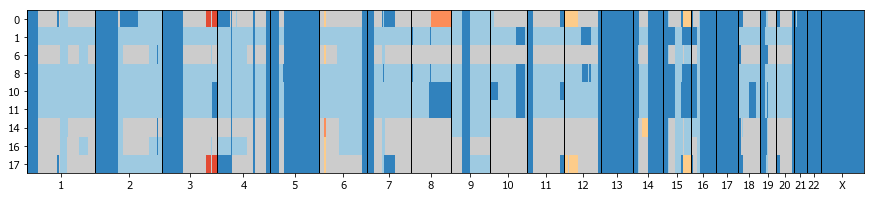

In [157]:

fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cluster_cn_matrix(ax, allele_cn, 'minor_cn')


In [128]:

snv_filenames = [
    'SA921_snv_annotations.h5',
    'SA922_snv_annotations.h5',
    'SA1090_snv_annotations.h5',
]

results_dir = '/Users/amcphers/Scratch/tov'

snv_filenames = [os.path.join(results_dir, filename) for filename in snv_filenames]


In [129]:

import scgenome.snvdata

snv_data = pd.concat([scgenome.snvdata.get_snv_results(filename) for filename in snv_filenames])

with pd.HDFStore('ov2295_snv_data.h5', 'w') as store:
    store['snv_data'] = snv_data

snv_data.head()


starting load
strelka (15214, 5)
museq (58724, 5)
finishing load (5682, 2)
starting load
strelka (16595, 5)
museq (61359, 5)
finishing load (6298, 2)
starting load
strelka (22751, 5)
museq (159387, 5)
finishing load (4975, 2)


/Users/amcphers/Projects/scgenome/venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['chrom', 'ref', 'alt', 'cell_id', 'is_cosmic', 'tri_nucleotide_context']]

  exec(code_obj, self.user_global_ns, self.user_ns)


,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,mappability,strelka_score,museq_score,is_cosmic,HIGH,LOW,MODERATE,MODIFIER,tri_nucleotide_context
0,8,145770028,G,C,0,1,SA921-A90554A-R03-C05,1.0,40,0.98,NaN,0,1,0,1,AGA
1,8,145770028,G,C,1,0,SA921-A90554A-R03-C28,1.0,40,0.98,NaN,0,1,0,1,AGA
2,8,145770028,G,C,1,0,SA921-A90554A-R03-C45,1.0,40,0.98,NaN,0,1,0,1,AGA
3,8,145770028,G,C,1,0,SA921-A90554A-R04-C08,1.0,40,0.98,NaN,0,1,0,1,AGA
4,8,145770028,G,C,1,0,SA921-A90554A-R04-C11,1.0,40,0.98,NaN,0,1,0,1,AGA


In [136]:

snv_counts_filenames = [
    'SA921_snv_counts.h5',
    'SA922_snv_counts.h5',
    'SA1090_snv_counts.h5',
]

snv_counts_filenames = [os.path.join(results_dir, filename) for filename in snv_counts_filenames]

snv_count_data = []

positions = snv_data[['chrom', 'coord', 'ref', 'alt']].drop_duplicates()

for filename in snv_counts_filenames:
    with pd.HDFStore(filename) as store:
        snv_count_data.append(store['/snv_allele_counts'].merge(positions, how='inner'))

snv_count_data = pd.concat(snv_count_data, ignore_index=True)


In [140]:

snv_data = snv_data.drop(['alt_counts', 'ref_counts'], axis=1)
snv_data = snv_data.merge(
    snv_count_data, how='outer',
    on=['chrom', 'coord', 'ref', 'alt', 'cell_id']).fillna(0)
snv_data['total_counts'] = snv_data['ref_counts'] + snv_data['alt_counts']
snv_data['sample_id'] = snv_data['cell_id'].apply(lambda a: a.split('-')[0])

assert not snv_data['coord'].isnull().any()
assert not snv_data['alt_counts'].isnull().any()

snv_data.head()


,chrom,coord,ref,alt,cell_id,mappability,strelka_score,museq_score,is_cosmic,HIGH,LOW,MODERATE,MODIFIER,tri_nucleotide_context,gm_umap_cluster,cluster_id,ref_counts,alt_counts,total_counts,sample_id
0,8,145770028,G,C,SA921-A90554A-R03-C28,1.0,40.0,0.98,0,0.0,1.0,0.0,1.0,AGA,6.0,6.0,1,0,1,SA921
1,1,177722716,G,T,SA921-A90554A-R03-C28,1.0,124.0,0.99,0,0.0,0.0,0.0,1.0,GGC,6.0,6.0,0,2,2,SA921
2,1,238181074,G,A,SA921-A90554A-R03-C28,1.0,92.0,1.00,0,0.0,0.0,0.0,1.0,TGT,6.0,6.0,1,0,1,SA921
3,10,54516752,G,A,SA921-A90554A-R03-C28,1.0,110.0,1.00,0,0.0,0.0,0.0,1.0,AGA,6.0,6.0,1,0,1,SA921
4,10,99361281,A,T,SA921-A90554A-R03-C28,1.0,133.0,1.00,0,0.0,0.0,0.0,1.0,AAG,6.0,6.0,1,0,1,SA921


In [142]:

if 'cluster_id' in snv_data:
    snv_data.drop(['cluster_id'], axis=1, inplace=True)
snv_data = snv_data.merge(cluster_df)


/Users/amcphers/Projects/scgenome/venv/lib/python2.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


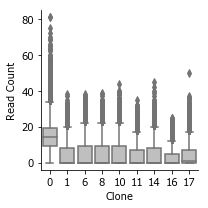

In [143]:

# Distribution of per variant total counts summed across clones

data2 = (
    snv_data.groupby(['chrom', 'coord', 'ref', 'alt', 'cluster_id'])[['total_counts', 'ref_counts', 'alt_counts']]
    .sum().unstack(fill_value=0).stack().reset_index())

plot_data = data2.rename(columns={
    'cluster_id': 'Clone',
    'total_counts': 'Read Count',
})

seaborn.factorplot(x='Clone', y='Read Count', kind='box', data=plot_data, color='0.75', size=3)


In [144]:

import sys
sys.setrecursionlimit(10000)

# min_total_counts_filter = min_total_counts[min_total_counts['total_counts'] >= 4]

sum_alt_counts = snv_data.groupby(['chrom', 'coord', 'ref', 'alt'])['alt_counts'].sum()
present_anywhere_filter = sum_alt_counts[sum_alt_counts > 0].reset_index().drop('alt_counts', axis=1)

data2 = snv_data.copy()
data2['sample_id'] = data2['cell_id'].apply(lambda a: a.split('-')[0])
data2 = data2.merge(cluster_df)
data2 = (
    data2.groupby(['chrom', 'coord', 'cluster_id'])[['alt_counts', 'ref_counts']]
    .sum().unstack(fill_value=0).stack().reset_index())
data2['total_counts'] = data2['ref_counts'] + data2['alt_counts']
data2['vaf'] = data2['alt_counts'] / data2['total_counts']
data2['alt_counts'] = data2['alt_counts'].clip_upper(10)
data2['is_present'] = (data2['alt_counts'] > 0) * 1
data2['is_absent'] = (data2['alt_counts'] == 0) * 1
data2['is_het'] = (data2['alt_counts'] < 0.99 * data2['total_counts']) * data2['is_present']
data2['is_hom'] = (data2['alt_counts'] >= 0.99 * data2['total_counts']) * data2['is_present']
data2['state'] = data2['is_hom'] * 3 + data2['is_het'] * 2 + data2['is_absent']
# data2 = data2[data2['total_counts'] > 0]
# data2 = data2.merge(min_total_counts_filter[['chrom', 'coord', 'ref', 'alt']])
data2 = data2.merge(present_anywhere_filter[['chrom', 'coord', 'ref', 'alt']])
data2 = data2.set_index(['chrom', 'coord', 'cluster_id'])['is_present'].unstack(fill_value=0)
print data2.shape


(12217, 9)


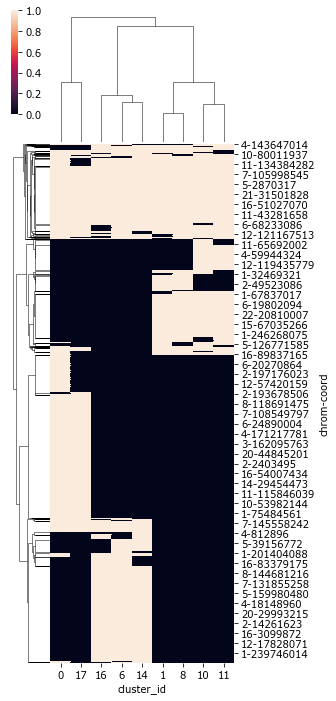

In [145]:

g = seaborn.clustermap(data2, rasterized=True, row_cluster=True, figsize=(4, 12))


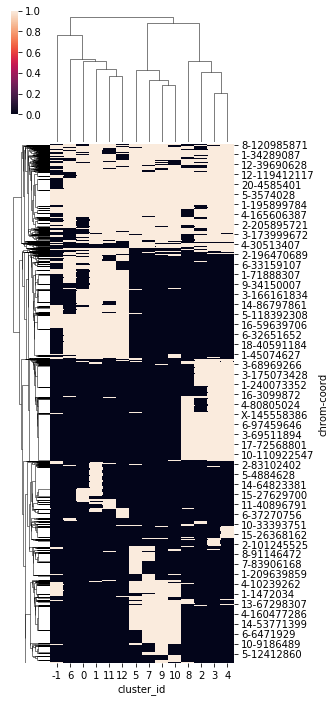

In [52]:

g = seaborn.clustermap(data2, rasterized=True, row_cluster=True, figsize=(4, 12))



# Breakpoints


In [161]:


def get_breakpoint_results(filename):
    store = pd.HDFStore(filename, 'r')

    print store['/breakpoint'].shape[0]

    data = store['/breakpoint']
    data = data.drop(['num_reads', 'num_unique_reads'], axis=1)
    data = data.merge(store['/breakpoint_library'], on='prediction_id')

    print data.shape[0]

    return data

breakpoint_filenames = [
    'SA921_destruct.h5',
    'SA922_destruct.h5',
    'SA1090_destruct.h5',
]

results_dir = '/Users/amcphers/Scratch/tov'

breakpoint_filenames = [os.path.join(results_dir, filename) for filename in breakpoint_filenames]

breakpoint_data = pd.concat([get_breakpoint_results(filename) for filename in breakpoint_filenames])
breakpoint_data.head()


333
2659
333
2659
333
2659


,prediction_id,chromosome_1,strand_1,position_1,chromosome_2,strand_2,position_2,homology,num_split,inserted,...,num_patients,is_filtered,dist_filtered,balanced,rearrangement_type,num_reads,num_unique_reads,library,is_normal,patient_id
0,2194,1,+,112676099,1,-,112676877,0,2,AAAT,...,1,False,1954.0,False,deletion,1,1,SA922-A90554B-R31-C51,False,NaN
1,2194,1,+,112676099,1,-,112676877,0,2,AAAT,...,1,False,1954.0,False,deletion,1,1,SA922-A90554B-R30-C34,False,NaN
2,2194,1,+,112676099,1,-,112676877,0,2,AAAT,...,1,False,1954.0,False,deletion,1,1,SA922-A90554B-R34-C16,False,NaN
3,2216,1,+,224504186,1,-,224402764,0,3,C,...,1,False,14815.0,False,duplication,1,1,SA922-A90554B-R33-C60,False,NaN
4,2216,1,+,224504186,1,-,224402764,0,3,C,...,1,False,14815.0,False,duplication,2,1,SA922-A90554B-R32-C38,False,NaN


In [162]:

breakpoint_data['cell_id'] = breakpoint_data['library']
breakpoint_data['sample_id'] = breakpoint_data['cell_id'].apply(lambda a: a.split('-')[0])
breakpoint_data['sample_id'].unique()


array(['SA922'], dtype=object)

In [55]:

breakpoint_data.iloc[0]


prediction_id                                                       2175
chromosome_1                                                           1
strand_1                                                               +
position_1                                                     112676099
chromosome_2                                                           1
strand_2                                                               -
position_2                                                     112676877
homology                                                               0
num_split                                                              2
inserted                                                            AAAT
mate_score                                                             0
template_length_1                                                    549
log_cdf                                                         -4.90961
template_length_2                                  

In [57]:

breakpoint_data = breakpoint_data.merge(cluster_df)
breakpoint_data.head()


,prediction_id,chromosome_1,strand_1,position_1,chromosome_2,strand_2,position_2,homology,num_split,inserted,...,num_reads,num_unique_reads,library,is_normal,patient_id,cell_id,sample_id,cluster_id,umap1,umap2
0,2175,1,+,112676099,1,-,112676877,0,2,AAAT,...,1,1,SA922-A90554B-R31-C51,False,NaN,SA922-A90554B-R31-C51,SA922,12,12.384187,-11.395905
1,10373,2,+,31017845,1,-,146015799,4,36,NaN,...,2,1,SA922-A90554B-R31-C51,False,NaN,SA922-A90554B-R31-C51,SA922,12,12.384187,-11.395905
2,54984,3,+,18236856,3,-,18230803,2,50,NaN,...,2,1,SA922-A90554B-R31-C51,False,NaN,SA922-A90554B-R31-C51,SA922,12,12.384187,-11.395905
3,128503,8,+,3803663,8,-,3947077,0,13,GCA,...,2,1,SA922-A90554B-R31-C51,False,NaN,SA922-A90554B-R31-C51,SA922,12,12.384187,-11.395905
4,2175,1,+,112676099,1,-,112676877,0,2,AAAT,...,1,1,SA922-A90554B-R30-C34,False,NaN,SA922-A90554B-R30-C34,SA922,11,12.791381,-12.315751


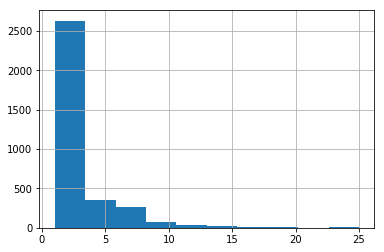

In [61]:

logical_index = [
    'chromosome_1', 'strand_1', 'position_1',
    'chromosome_2', 'strand_2', 'position_2',
    ]

data = breakpoint_data.groupby(logical_index + ['cluster_id'])[['num_reads', 'num_unique_reads']].sum().reset_index()

data['num_reads'].hist()


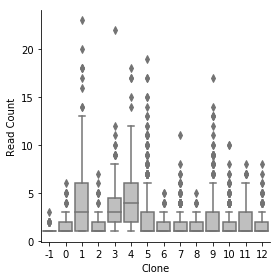

In [70]:

import seaborn

plot_data = data.rename(columns={
    'cluster_id': 'Clone',
    'num_unique_reads': 'Read Count',
})

seaborn.factorplot(y='Read Count', x='Clone', kind='box', data=plot_data, color='0.75', size=4)


   chromosome_1 strand_1  position_1 chromosome_2 strand_2  position_2  \
23            1        +    28145735            1        -    28139760   
24            1        +    28145735            1        -    28139760   
25            1        +    28145735            1        -    28139760   
26            1        +    28145735            1        -    28139760   
27            1        +    28145735            1        -    28139760   
28            1        +    28145735            1        -    28139760   
29            1        +    28145735            1        -    28139760   
30            1        +    28145735            1        -    28139760   
31            1        +    28145735            1        -    28139760   
32            1        +    28145735            1        -    28139760   
33            1        +    28145735            1        -    28139760   

    cluster_id  num_unique_reads  is_present  
23          -1               1.0           1  
24           0   

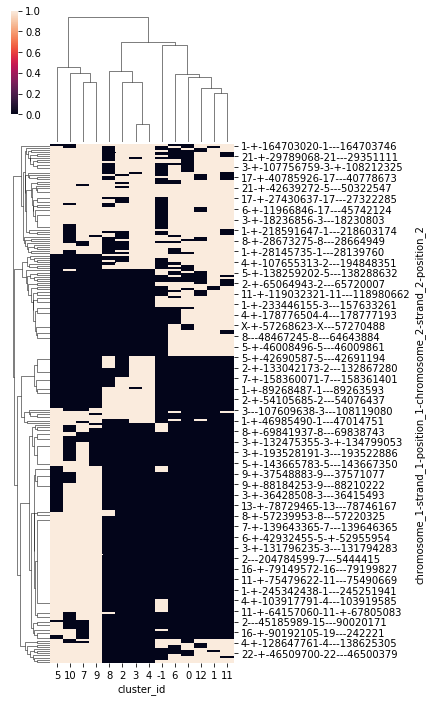

In [67]:

import seaborn
import sys
sys.setrecursionlimit(10000)

data2 = breakpoint_data.copy()

filtered = breakpoint_data.copy()
filtered = filtered[filtered['num_split'] > 4]
filtered = filtered[filtered['template_length_min'] > 250]
filtered = filtered[logical_index].drop_duplicates()

data2 = (
    data2.groupby(logical_index + ['cluster_id'])[['num_unique_reads']]
    .sum().unstack(fill_value=None).stack().reset_index())
data2['is_present'] = (data2['num_unique_reads'] > 0) * 1

print data2.query('position_1 == 28145735')

data2 = data2.merge(filtered)
data2 = data2.set_index(logical_index + ['cluster_id'])['is_present'].unstack(fill_value=None).fillna(0)

mask = data2.isnull()
g = seaborn.clustermap(data2, mask=mask, rasterized=True, figsize=(4, 12))


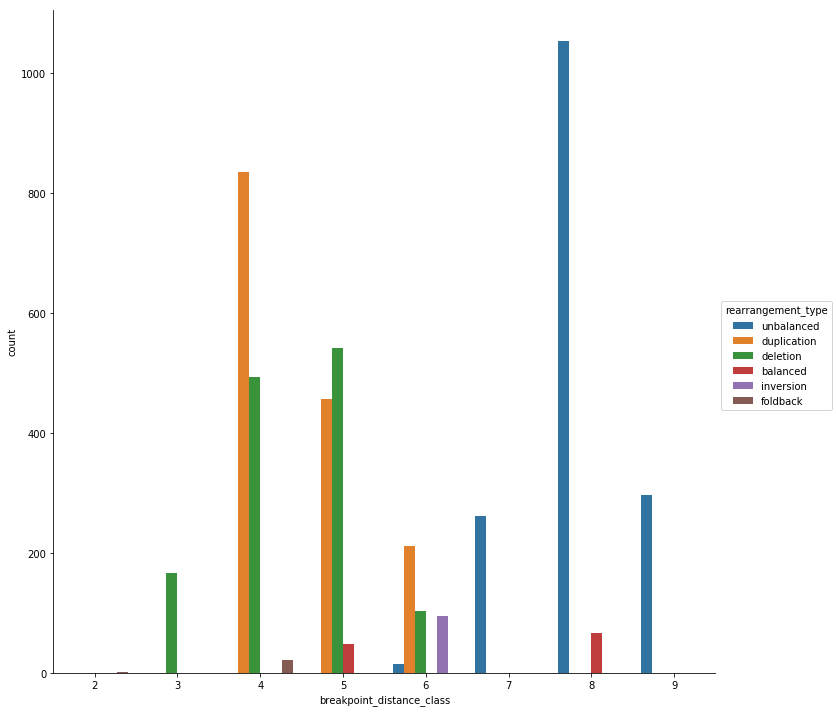

In [72]:

import numpy as np

filtered = breakpoint_data.copy()
filtered = filtered[filtered['num_split'] > 4]
filtered = filtered[filtered['template_length_min'] > 250]
filtered['breakpoint_distance'] = (filtered['position_1'] - filtered['position_2']).abs()
bins = np.logspace(0, np.log10(1e10), 11)
filtered['breakpoint_distance_class'] = np.digitize(filtered['breakpoint_distance'], bins)

seaborn.factorplot(hue='rearrangement_type', x='breakpoint_distance_class', data=filtered, kind='count', size=10)
